# Analysis: Value Sensitivity (The Sniper Test)

**Hypothesis:** The agent is a **Value Sniper**. It only bets Outsider/Draw when the simulation noise creates a "Mispricing" (High Value).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
import os
import sys
import torch

# Add project root to path to import core logic
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from mpp_project.core import get_observation

def get_value_observation(gap_to_leader, outsider_value_factor, matches_rem=1):
    # 1. PROBABILITIES (With Tie-Breaker)
    p_fav = 0.50
    # Make Draw slightly more probable than Outsider to lock the sort order
    # Order will ALWAYS be: 0=Fav, 1=Draw, 2=Outsider
    p_draw = 0.251  
    p_out = 0.249
    probas = np.array([p_fav, p_draw, p_out])

    # 2. AUTHENTIC GAINS
    ev_avg = 35.0
    p_clipped = np.maximum(probas, 0.001)
    ev_factor = -2.54 * (p_clipped**2) + 3.14 * p_clipped + 0.21
    raw_gains = (ev_factor * ev_avg) / p_clipped

    # 3. APPLY VALUE FACTOR TO OUTSIDER
    gains = raw_gains.copy()
    gains[2] *= outsider_value_factor

    # 4. REPARTITION
    repart_fav = 1 - (1 - p_fav)**2
    repart_draw = (1 - repart_fav) * 0.6
    repart_out = 1 - repart_fav - repart_draw
    repart = np.array([repart_fav, repart_draw, repart_out])

    # 5. SCORES
    scores = np.zeros(12)
    scores[0] = 1000.0
    scores[1] = 1000.0 - gap_to_leader
    scores[2:] = 900.0

    # 6. DYNAMIC CONTEXT
    total_matches = 51
    matches_remaining_fraction = matches_rem / total_matches
    future_max_points = np.max(gains) * matches_rem

    # 7. CALL CORE BUILDER
    obs, sort_idx = get_observation(
        match_probas=probas,
        match_gains=gains,
        opp_repartition=repart,
        player_scores=scores,
        agent_idx=0,
        future_max_points=future_max_points,
        matches_remaining_fraction=matches_remaining_fraction,
        ev_avg=ev_avg
    )

    return obs, sort_idx, probas, gains

In [29]:
# --- Configuration ---
# Ensure you point to the correct Phase 2 model for now
MODEL_PATH = "../models_v3/ppo_v3_phase4_domain_rand.zip" 
model = PPO.load(MODEL_PATH)

# Grid definition
gaps = np.linspace(-500, 500, 50)
# Value Factor: 0.8 (Bad Price) to 2.0 (Double Price / Huge Value)
value_factors = np.linspace(0.6, 2.0, 50)

policy_map = np.zeros((len(value_factors), len(gaps)))

print("Scanning for Value Sensitivity (Last Match Scenario)...")

for i, val in enumerate(value_factors):
    for j, gap in enumerate(gaps):
        # Force matches_rem=1 to trigger desperation logic
        obs, sort_idx, _, _ = get_value_observation(gap, val, matches_rem=1)
        
        # Predict
        action_sorted, _ = model.predict(obs, deterministic=True)
        
        # Unsort to get Real Outcome (0=Fav, 1=Draw, 2=Out)
        real_action = sort_idx[action_sorted]
        
        policy_map[i, j] = real_action

print("Scan complete.")

Scanning for Value Sensitivity (Last Match Scenario)...
Scan complete.


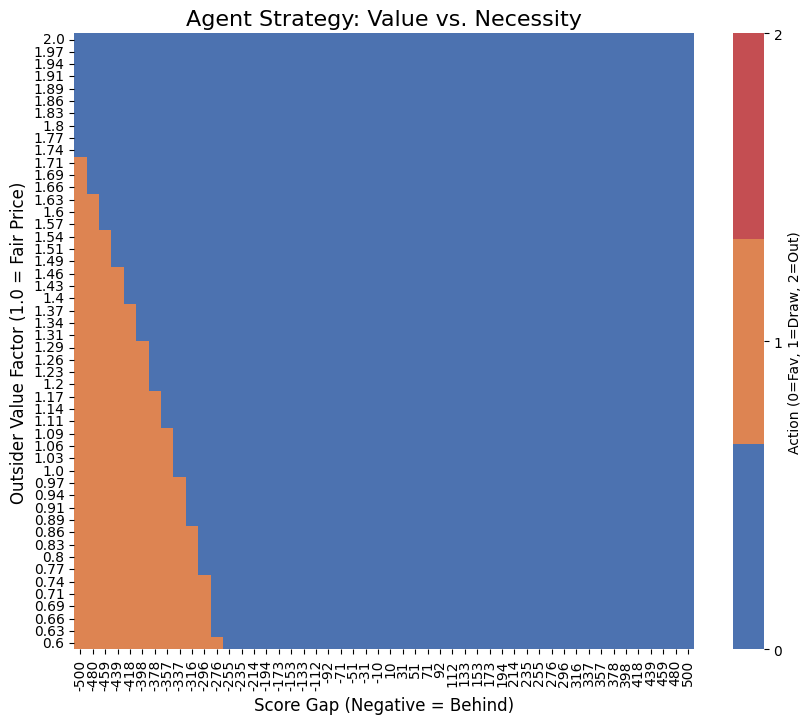

In [30]:
plt.figure(figsize=(10, 8))
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#4c72b0', '#dd8452', '#c44e52'])

ax = sns.heatmap(policy_map, 
                 xticklabels=np.round(gaps).astype(int), 
                 yticklabels=np.round(value_factors, 2),
                 cmap=cmap, vmin=0, vmax=2,
                 cbar_kws={'ticks': [0, 1, 2], 'label': 'Action (0=Fav, 1=Draw, 2=Out)'})

plt.gca().invert_yaxis()
plt.title("Agent Strategy: Value vs. Necessity", fontsize=16)
plt.xlabel("Score Gap (Negative = Behind)", fontsize=12)
plt.ylabel("Outsider Value Factor (1.0 = Fair Price)", fontsize=12)
plt.show()

In [17]:
def probe_agent_decision(gap, val_factor, scenario_name):
    obs, sort_idx, probas, gains = get_value_observation(gap, val_factor)
    
    obs_tensor = torch.as_tensor(obs).unsqueeze(0).to(model.device)
    with torch.no_grad():
        sorted_probs = model.policy.get_distribution(obs_tensor).distribution.probs.cpu().numpy()[0]
    
    # Unsort
    original_probs = np.zeros(3)
    original_probs[sort_idx] = sorted_probs
    
    print(f"\n--- SCENARIO: {scenario_name} ---")
    print(f"Inputs: Gap={gap} | Outsider Value Factor={val_factor}x")
    print(f"Match:  Fav={probas[0]:.0%} (Gain={gains[0]:.1f}) | Draw={probas[1]:.0%} (Gain={gains[1]:.1f}) | Out={probas[2]:.0%} (Gain={gains[2]:.1f})")
    print(f"Policy: Fav={original_probs[0]:.1%} | Draw={original_probs[1]:.1%} | OUTSIDER={original_probs[2]:.1%}")
    print(f"Choice: {['Fav', 'Draw', 'Out'][np.argmax(original_probs)]}")

probe_agent_decision(gap=-300, val_factor=3.5, scenario_name="Desperate & Huge Value")
probe_agent_decision(gap=300, val_factor=3.5, scenario_name="Comfortable & Huge Value")
probe_agent_decision(gap=-300, val_factor=0.7, scenario_name="Desperate & Bad Price")
probe_agent_decision(gap=-100, val_factor=0.9, scenario_name="Nuclear Value (2.5x)")


--- SCENARIO: Desperate & Huge Value ---
Inputs: Gap=-300 | Outsider Value Factor=3.5x
Match:  Fav=50% (Gain=80.2) | Draw=25% (Gain=116.9) | Out=25% (Gain=410.5)
Policy: Fav=100.0% | Draw=0.0% | OUTSIDER=0.0%
Choice: Fav

--- SCENARIO: Comfortable & Huge Value ---
Inputs: Gap=300 | Outsider Value Factor=3.5x
Match:  Fav=50% (Gain=80.2) | Draw=25% (Gain=116.9) | Out=25% (Gain=410.5)
Policy: Fav=100.0% | Draw=0.0% | OUTSIDER=0.0%
Choice: Fav

--- SCENARIO: Desperate & Bad Price ---
Inputs: Gap=-300 | Outsider Value Factor=0.7x
Match:  Fav=50% (Gain=80.2) | Draw=25% (Gain=116.9) | Out=25% (Gain=82.1)
Policy: Fav=34.3% | Draw=64.3% | OUTSIDER=1.4%
Choice: Draw

--- SCENARIO: Nuclear Value (2.5x) ---
Inputs: Gap=-100 | Outsider Value Factor=0.9x
Match:  Fav=50% (Gain=80.2) | Draw=25% (Gain=116.9) | Out=25% (Gain=105.6)
Policy: Fav=100.0% | Draw=0.0% | OUTSIDER=0.0%
Choice: Fav
